## Application: Hedonic Price Function of Houses
---

#### Dependent variable

+ price    - sale price of a house

#### Independent variables

+ lotsize  - lot size of a property in square feet
+ bedrooms - number of bedrooms
+ bathrms  - number of full bathrooms
+ stories  - number of stories excluding basement
+ driveway - does the house has a driveway?
+ recroom  - does the house has a recreational room?
+ fullbase - does the house has a full finished basement?
+ gashw    - does the house uses gas for hot water heating?
+ airco    - does the house has central air conditioning?
+ garagepl - number of garage places
+ prefarea - is the house located in the preferred neighbourhood of the city?

#### Source:

Sales Prices of Houses in the City of Windsor

https://vincentarelbundock.github.io/Rdatasets/datasets.html

Anglin, P.M. and R. Gencay (1996) “Semiparametric estimation of a hedonic price function,” Journal of Applied Econometrics, 11(6), 633-648.


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
from IPython.display import display
# workaround for Theano compilation errors
import theano
theano.config.gcc.cxxflags = '-Wno-c++11-narrowing'
# ignore warnings
import warnings 
warnings.simplefilter('ignore')

#### Hedonic regression model

$$
 \log(\text{price})
 = \text{constant}
 + \beta_1\log(\text{lotsize})
 + \beta_2\text{bedrooms}
 + \beta_3\text{bathrms}
 + \beta_4\text{stories}
 + \beta_5\text{driveway}
 + \beta_6\text{recroom}
 + \beta_7\text{fullbase}
 + \beta_8\text{gashw}
 + \beta_9\text{airco}
 + \beta_{10}\text{garagepl}
 + \beta_{11}\text{prefarea}
 + \text{error}.
$$

In [2]:
data = pd.read_csv('Housing.csv', index_col=0)
column_names = data.columns
qualitative = ['driveway', 'recroom', 'fullbase', 'gashw', 'airco', 'prefarea']
dummy = data[qualitative].replace(['yes', 'no'], [1, 0])
data[qualitative] = dummy
data['lotsize'] = np.log(data['lotsize'])
n = data.shape[0]
y = np.log(data['price'].values)
X = np.hstack((np.ones((y.size, 1)), data[column_names[1:]].values))
var_names = np.concatenate((['constant'], column_names[1:], ['$\\sigma^2$']))

The prior distribution of $\beta$ and $\sigma^2$ are

\begin{align*}
 \beta &\sim \mathrm{Normal}\left(\mu_\beta,\Omega_\beta\right), \\
 \sigma^2 &\sim \mathrm{Inv.Gamma}\left(\frac{\nu_0}{2},\frac{\lambda_0}{2}\right).
\end{align*}

We set

$$
 \mu_{\beta} = \begin{bmatrix} 0 \\ \vdots \\ 0 \end{bmatrix},\ 
 \Omega_{\beta} = 
 \begin{bmatrix} 100 & \dots & 0 \\ \vdots & \ddots & \vdots \\ 0 & \dots & 100 \end{bmatrix},\ 
 \nu_0 = 0.02,\ \lambda_0 = 0.02.
$$


In [3]:
k = X.shape[1]
mu_b = np.zeros(k)
Omega_b = 100.0 * np.eye(k)
nu0 = 0.02
lam0 = 0.02

#### Model setup

In the with statement, the prior distribution of $\sigma^2$ is the same inverse gamma distribution. The prior distribution of the regressio coefficients $\beta$ is spacified as the following $k$-dimensional multivariate normal distribuiton.

```Python
    b = pm.MvNormal('b', mu=mu_b, cov=Omega_b, shape=k)
```

where `mu` is the mean vector, `cov` is the covariance matrix, and `shape` is the demension of the distribution.

`math.dot` computes the inner product between vectors/matrices.


In [4]:
multiple_regression = pm.Model()
with multiple_regression:
    sigma2 = pm.InverseGamma('sigma2', alpha=0.5*nu0, beta=0.5*lam0)
    b = pm.MvNormal('b', mu=mu_b, cov=Omega_b, shape=k)
    y_hat = pm.math.dot(X, b)
    likelihood = pm.Normal('y', mu=y_hat, sd=pm.math.sqrt(sigma2), observed=y)

#### Markov chain sampling

In [5]:
n_draws = 5000
n_chains = 4
n_tune = 1000
with multiple_regression:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)
sim_param = dict([(var, trace['b'][:, index]) for index, var in enumerate(var_names[:-1])])
sim_param[var_names[-1]] = trace['sigma2']

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, sigma2]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [01:39<00:00, 240.91draws/s]


In [6]:
post_stats = pm.summary(trace)
post_stats.index = var_names
display(post_stats)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
constant,7.740,0.218,7.328,8.149,0.002,0.002,10497.0,10497.0,10494.0,11748.0,1.0
lotsize,0.304,0.027,0.254,0.355,0.000,0.000,10120.0,10038.0,10114.0,12106.0,1.0
bedrooms,0.034,0.014,0.008,0.062,0.000,0.000,16117.0,15402.0,16116.0,14263.0,1.0
bathrms,0.166,0.020,0.129,0.205,0.000,0.000,18236.0,18177.0,18216.0,15186.0,1.0
stories,0.092,0.013,0.068,0.115,0.000,0.000,15180.0,15162.0,15181.0,14149.0,1.0
driveway,0.110,0.028,0.057,0.163,0.000,0.000,17213.0,16792.0,17234.0,14005.0,1.0
recroom,0.058,0.026,0.009,0.107,0.000,0.000,18143.0,17475.0,18147.0,14617.0,1.0
fullbase,0.105,0.022,0.063,0.144,0.000,0.000,16667.0,16473.0,16683.0,15153.0,1.0
gashw,0.179,0.044,0.096,0.259,0.000,0.000,19190.0,18769.0,19180.0,14959.0,1.0
airco,0.166,0.021,0.127,0.206,0.000,0.000,17182.0,17142.0,17184.0,14357.0,1.0


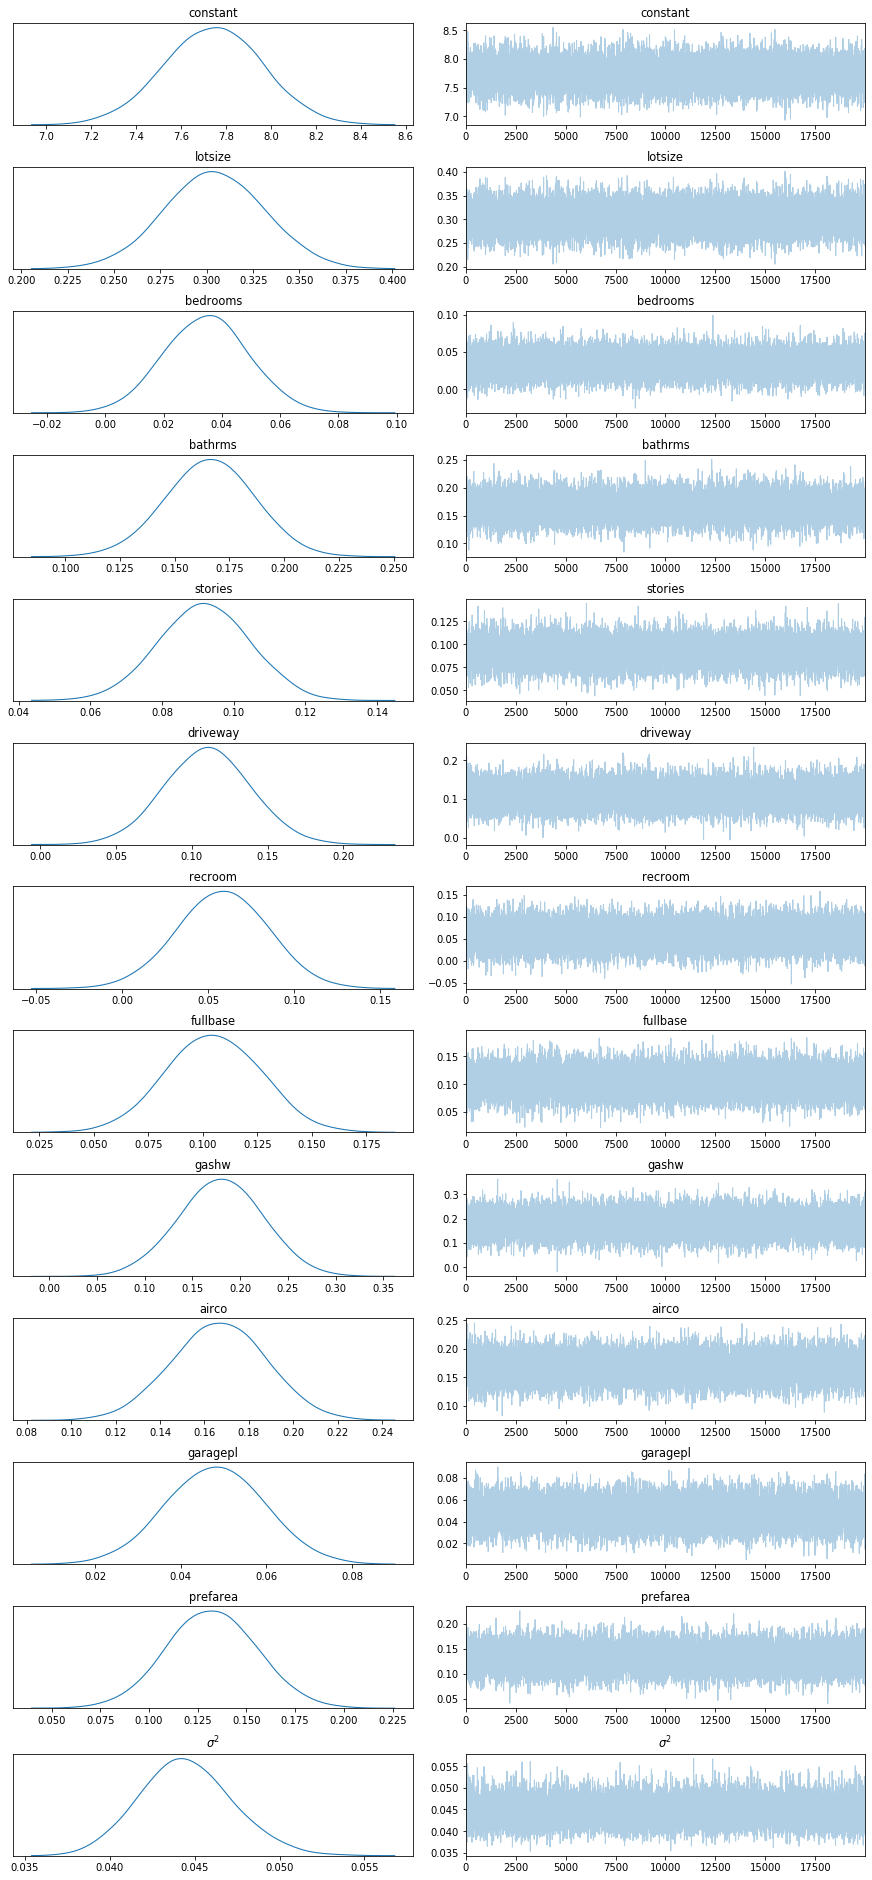

In [7]:
pm.traceplot(sim_param)
plt.show()

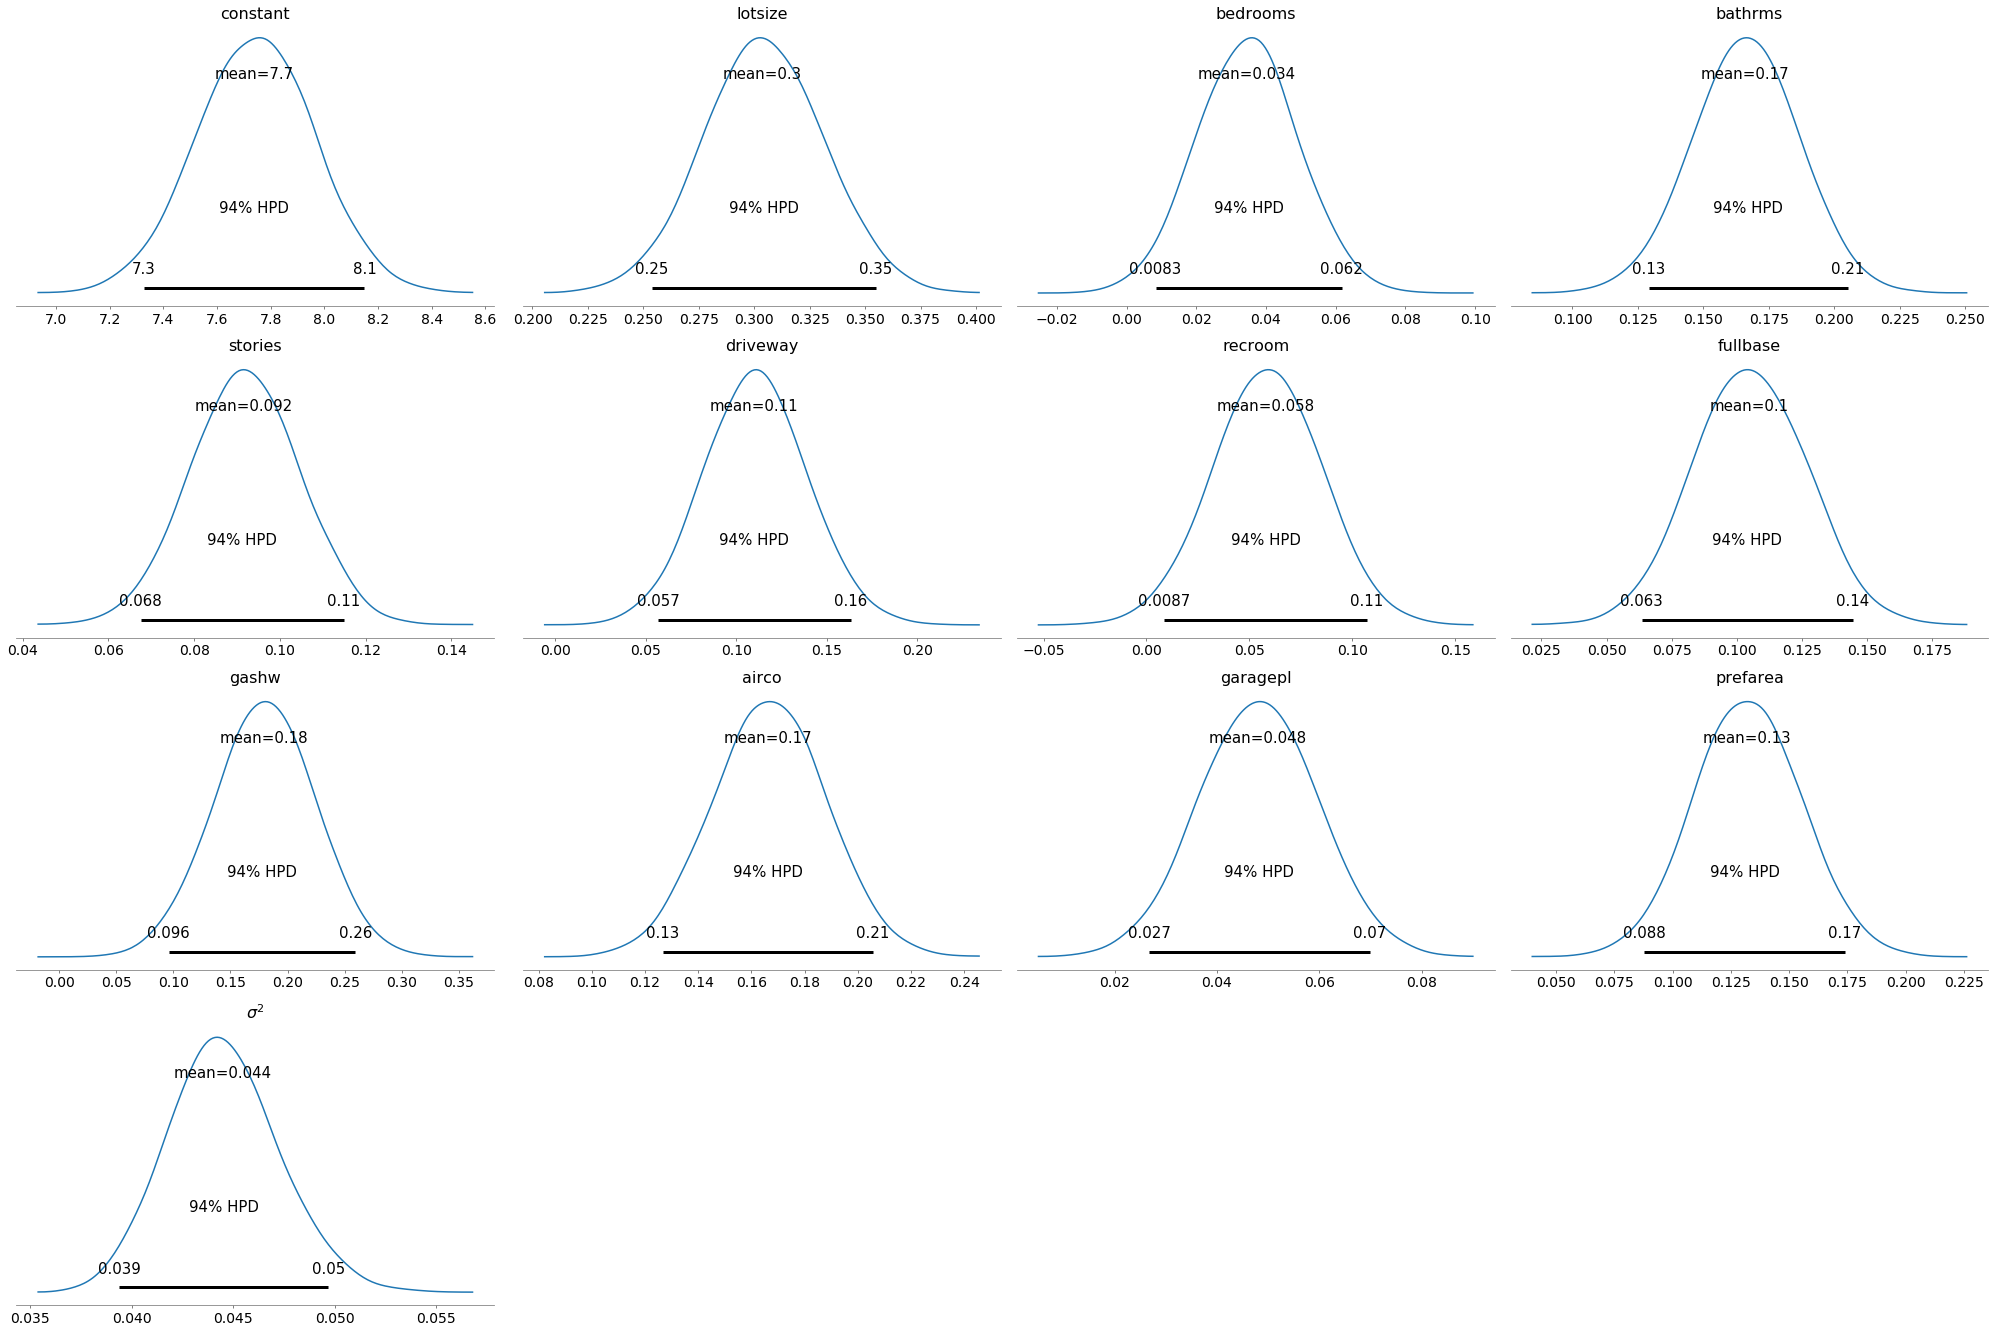

In [8]:
pm.plot_posterior(sim_param, kind='kde', point_estimate='mean')
plt.show()